## Network analysis notebook

### Republican likes network

In [1]:
import tweepy
import json
import pickle
import os
import pandas as pd
import networkx as nx

from code import utils, pipelines
from code.graph import Political_Graph
from code.representative import Representative

import matplotlib.pyplot as plt
%matplotlib inline

### Republican interactions

In [2]:
data = pd.read_csv('data/representatives.csv', index_col='Twitter')
data.head()

,State,Chamber of Congress,Name,Party,screen_name
Twitter,,,,,
@SenShelby,Alabama,Senator,Richard Shelby,R,SenShelby
@DougJones,Alabama,Senator,Doug Jones,D,DougJones
@RepByrne,Alabama 1st District,Representative,"Byrne, Bradley",R,RepByrne
@RepMarthaRoby,Alabama 2nd District,U.S. Representative,"Roby, Martha",R,RepMarthaRoby
@RepMikeRogersAL,Alabama 3rd District,U.S. Representative,"Rogers, Mike",R,RepMikeRogersAL


In [3]:
data_groups = data.groupby('Party')

republicans = data_groups.get_group('R')
democrats = data_groups.get_group('D')

In [4]:
republicans.head()

,State,Chamber of Congress,Name,Party,screen_name
Twitter,,,,,
@SenShelby,Alabama,Senator,Richard Shelby,R,SenShelby
@RepByrne,Alabama 1st District,Representative,"Byrne, Bradley",R,RepByrne
@RepMarthaRoby,Alabama 2nd District,U.S. Representative,"Roby, Martha",R,RepMarthaRoby
@RepMikeRogersAL,Alabama 3rd District,U.S. Representative,"Rogers, Mike",R,RepMikeRogersAL
@Robert_Aderholt,Alabama 4th District,U.S. Representative,"Aderholt, Robert",R,Robert_Aderholt


In [5]:
democrats.head()

,State,Chamber of Congress,Name,Party,screen_name
Twitter,,,,,
@DougJones,Alabama,Senator,Doug Jones,D,DougJones
@RepTerriSewell,Alabama 7th District,U.S. Representative,"Sewell, Terri A.",D,RepTerriSewell
@SenatorSinema,Arizona,U.S. Senator,"Sinema, Kyrsten",D,SenatorSinema
@TomOHalleran,Arizona 1st District,U.S. Representative,"O'Halleran, Tom",D,TomOHalleran
@RepKirkPatrick,Arizona 2nd District,U.S. Representative,"Kirkpatrick, Ann",D,RepKirkPatrick


## Building the republican network

First build the representative classes

In [6]:
republican_representatives = []

for index, row in republicans.iterrows():
    republican_representatives.append(Representative(*row))

In [7]:
with open('data/republican_likes.pkl', 'rb') as f:
    republican_likes_list = pickle.load(f)
    
republican_likes = {}
for rep, likes in republican_likes_list:
    republican_likes[rep] = likes

In [8]:
for rep in republican_representatives:
    rep.parse_user('data/rep/')
    rep.update_likes(republican_likes[rep.screen_name])

In [9]:
republican_network = Political_Graph(republican_representatives[:50])

In [10]:
republican_network.are_representatives_parsed()

True

In [11]:
republican_network.add_interactions('likes', color='green')
republican_network.add_interactions('mentions', color='red')
republican_network.add_interactions('retweets', color='blue')

In [12]:
republican_network.get_isolated_nodes()

[]

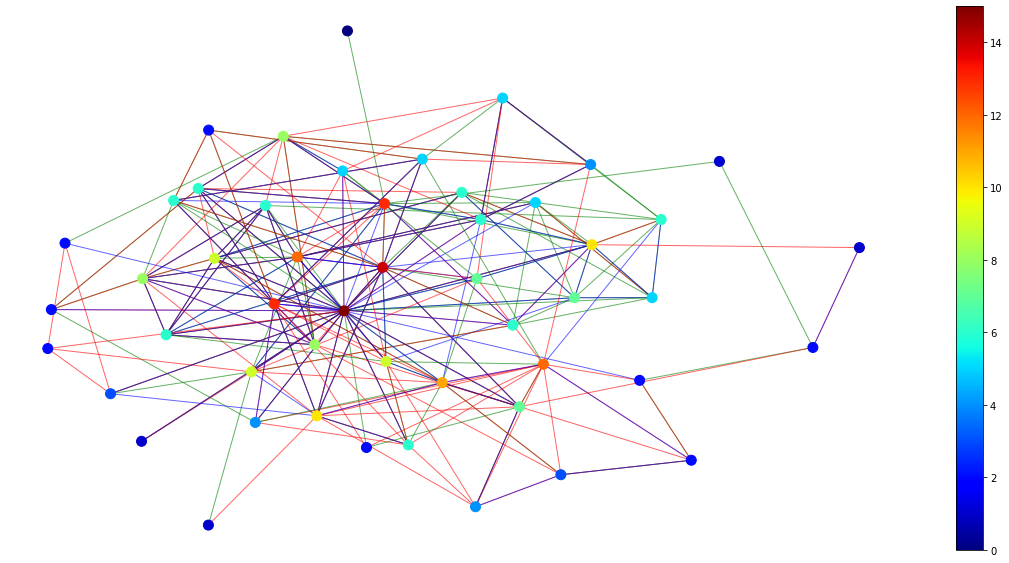

In [13]:
republican_network.draw_graph(layout=nx.kamada_kawai_layout, edge_attrs={'alpha':0.6}, node_attrs={'node_size': 100})

In [14]:
print(
    nx.is_connected(republican_network.graph),
    nx.is_directed(republican_network.graph),
    nx.diameter(republican_network.graph),
)

True False 4


In [15]:
republican_corpus = utils.get_hashtag_corpus(republican_representatives)
sorted(list(republican_corpus.items()), key=lambda x: x[1], reverse=True)[:10]

[('covid19', 3430),
 ('coronavirus', 1236),
 ('ppp', 616),
 ('paycheckprotectionprogram', 580),
 ('usmca', 521),
 ('ksleg', 446),
 ('ks02', 428),
 ('scotus', 386),
 ('sotu', 386),
 ('china', 384)]

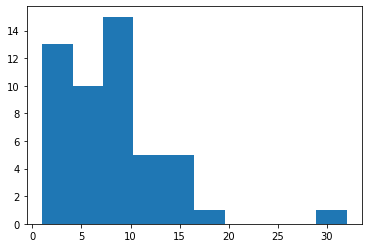

In [16]:
plt.hist(nx.get_node_attributes(republican_network.graph, 'count').values())
plt.show()

In [17]:
full_republican_network = Political_Graph(republican_representatives)

In [18]:
full_republican_network.add_interactions('likes', color='green')
full_republican_network.add_interactions('mentions', color='red')
full_republican_network.add_interactions('retweets', color='blue')

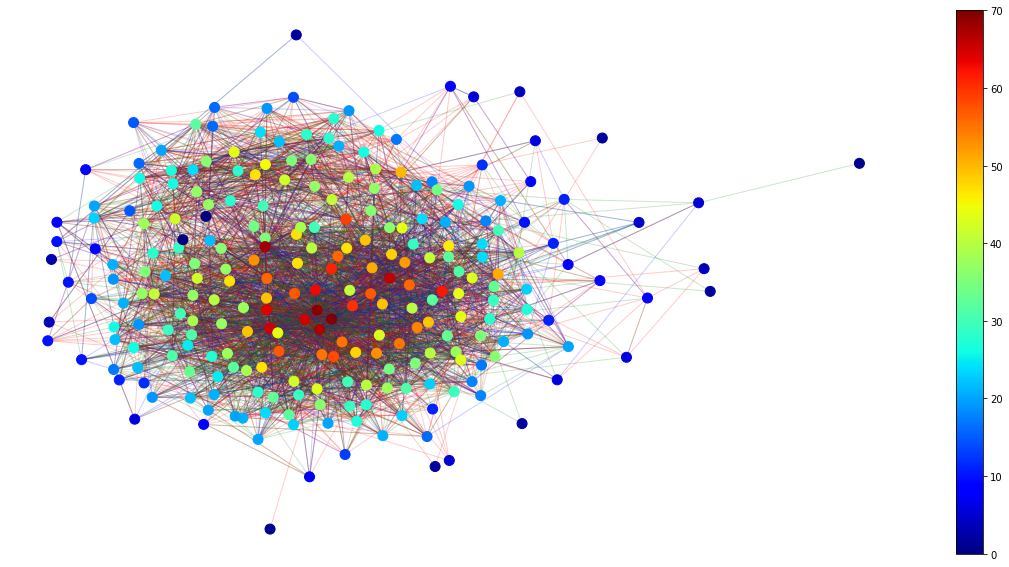

In [19]:
full_republican_network.draw_graph(layout=nx.kamada_kawai_layout, edge_attrs={'alpha':0.2}, node_attrs={'node_size': 100})

In [31]:
## Need to change the nodes from the representative class to a dict to be able to convert to gephi format...
## delete now, todo: find a better way to do this

## for node in full_republican_network.graph.nodes():
##    del full_republican_network.graph.nodes()[node]['meta']

## This is a worse solution but cooler

for node in full_republican_network.graph.nodes():
    repr_node = full_republican_network.graph.nodes()[node]
    repr_node.update(repr_node['meta'].__dict__())
    del full_republican_network.graph.nodes()[node]['meta']

In [32]:
nx.write_gexf(full_republican_network.graph, 'data/full_republican_graph.gexf')

In [18]:
for node in republican_network.graph.nodes():
    repr_node = republican_network.graph.nodes()[node]
    repr_node.update(repr_node['meta'].__dict__())
    del republican_network.graph.nodes()[node]['meta']

In [34]:
nx.write_gexf(republican_network.graph, 'data/republican_graph.gexf')

In [59]:
republican_network.graph.nodes()['SenShelby']

{'count': 8,
 'state': 'Alabama',
 'chamber_of_congress': 'Senator',
 'name': 'Richard Shelby',
 'screen_name': 'SenShelby',
 'party': 'R'}

In [23]:
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool, BoxZoomTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, from_networkx

In [39]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@image" height="42" alt="@image" width="42"
                style="float: left; margin: 0px 25px 25px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@name</span>
        </div>
        <br>
        <br>
        <div>
            <span style="font-size: 15px;">@chamber_of_congress</span>
        </div>
        <div>
            <span style="font-size: 15px;">@state</span>
        </div>
    </div>
"""

In [46]:
plot = Plot(plot_width=1200, plot_height=800,
            x_range=Range1d(-2.5, 2.5), y_range=Range1d(-2.5, 2.5))

node_hover_tool = HoverTool(tooltips=TOOLTIPS)
plot.add_tools(node_hover_tool, TapTool(), BoxZoomTool())

graph_renderer = from_networkx(republican_network.graph, nx.kamada_kawai_layout, scale=2, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=20, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=25, fill_color=Spectral4[3])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)

plot.renderers.append(graph_renderer)
output_file("interactive_graphs.html")

In [47]:
show(plot)